# Attempt to extract bedloads from seismic and river discharge time series

Originally by Brad Lipovsky (bpl7@uw.edu), modified by Marine Denolle (mdenolle@uw.edu) and Claude Sonnet.
Modified 
This notebook :
- pulls a metadata of pairs of seismic stations and river gages
- pulls the river gage data from USGS
- download seismic power from from UW/CC stations with obspy, exclude earthquake signals.
- 


It then computes a simple **band-limited RMS proxy** (a stand-in for “river rumble”/bedload-related noise used in Roth/Gimbert-style workflows) and compares it to gauge stage/discharge to look for **lag and hysteresis** (proxy persisting after gauges recede).


---

In [22]:
# If you don't have these yet:
# !pip install obspy pandas numpy scipy matplotlib requests lxml

import re
import sys
import importlib
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from zoneinfo import ZoneInfo

from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.signal.filter import bandpass

# Make sure we can import notebooks/utils.py whether the notebook cwd is repo root or notebooks/
_cwd = Path.cwd()
_candidates = [_cwd, _cwd / "notebooks", _cwd.parent, _cwd.parent / "notebooks"]
for _d in _candidates:
    if (_d / "utils.py").exists():
        sys.path.insert(0, str(_d))
        break

# Force-reload utils so edits are picked up in an already-running kernel
try:
    import utils as _utils
    importlib.reload(_utils)
except Exception as _e:
    print(f"Warning: utils reload failed: {_e}")

# Import all notebook helpers after sys.path setup
from utils import (
    load_station_gage_pairs,
    fetch_usgs_gage_timeseries,
    download_streams,
    fetch_usgs_event_times,
    stream_to_proxy_timeseries,
    estimate_constant_lag_seconds,
    plot_proxy_and_gauge,
    hysteresis_plot,
    band_sweep,
 )

plt.rcParams["figure.dpi"] = 120


In [23]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

## Configuration

Adjust the time window and frequency bands here. The default window is **Dec 7–14, 2025 (UTC)** to bracket the main atmospheric-river impacts and any post-peak rumble.

Tip: Start with a broad band like **5–30 Hz**, then sweep bands (e.g. 2–8, 5–15, 10–30) to find where the river signal is clearest at each station.


In [ ]:
# --- Time window (UTC) ---
START = UTCDateTime("2025-12-01T00:00:00")
END   = UTCDateTime("2025-12-14T00:00:00")

# --- Metadata source (station ↔ USGS gage pairs) ---
METADATA_CSV_URL = (
    "https://raw.githubusercontent.com/gaia-hazlab/gaia-data-downloaders/main/"
    "stations_by_basin_with_gages.csv"
 )

# Filter down the metadata to a manageable subset (optional)
NETWORK_FILTER = ["CC"]                 # seismic networks to include
BASIN_FILTER = None              # e.g. ["Cowlitz"], ["Puyallup"], or None for all
MAX_PAIRS = None                         # limit for quick iteration; set None for all

# Focus on a single station (set None to run all loaded pairs)
FOCUS_SEIS_KEY = "CC.PR02"

# --- Proxy definition (science-plan aligned) ---
PROXY_METHOD = "bandpower"              # "bandpower" (PSD-integrated) or "rms"
USE_RSS = True                           # True: combine Z/N/E as RSS; False: Z-only preferred
COMPONENTS = ("Z", "N", "E")

# --- Default band + windowing (10 min window, 5 min step) ---
FMIN, FMAX = 5.0, 30.0      # Hz
WIN_SECONDS = 600
STEP_SECONDS = 300

# Candidate bands for CC.PR01 band exploration (edit as needed)
FLOW_BANDS = [(0.5, 2.0), (1.0, 5.0), (2.0, 8.0)]
BEDLOAD_BANDS = [(5.0, 15.0), (10.0, 30.0)]

# --- Constant lag scan settings (proxy vs discharge) ---
LAG_MAX_HOURS = 24
LAG_STEP_MINUTES = 10

# --- Impulse clipping (STA/LTA) ---
# If any impulsive transient is detected within a UTC day, we clip the *entire day's*
# waveform to ±(CLIP_SIGMA * std_of_that_day).
CLIP_IMPULSES = True
STA_SECONDS = 1.0
LTA_SECONDS = 20.0
TRIGGER_ON = 3.5
TRIGGER_OFF = 1.0
CLIP_SIGMA = 2.0
CLIP_MODE = "symmetric"   # "symmetric" (±thr) or "upper" (+thr only)

# --- Earthquake exclusion (USGS catalog masking) ---
EXCLUDE_EARTHQUAKES = True
EQ_MIN_MAG = 3.5
EQ_MAXRADIUS_KM = 500
EQ_BUFFER_SECONDS = 20 * 60  # drop proxy windows within +/- this of origin time

# --- Extra outlier removal on proxy series (post-processing) ---
# This catches isolated spikes that slip through EQ masking/impulse clipping.
DESPIKE_PROXY = True
DESPIKE_WINDOW = "6H"          # rolling window for median/MAD (e.g., "2H", "6H")
DESPIKE_Z = 8.0                # robust z threshold; increase to be less aggressive
DESPIKE_MIN_PERIODS = 10
DESPIKE_FILL = "interpolate"          # "none" leaves NaNs; "interpolate" fills gaps

# --- Output choice for response removal ---
OUTPUT = "velocity"  # "acceleration" or "velocity"

## 1) Load station↔gage metadata + download USGS gauge data

We’ll use the GAIA HazLab metadata table to define which seismic stations pair with which USGS gages:
- metadata CSV: `stations_by_basin_with_gages.csv`
- key columns: `network`, `station`, `gage_id`, `basin_name`, `latitude`, `longitude`

Some seismic stations appear with **multiple candidate gages** in the GAIA table.
We automatically choose the **closest gage** for each station by:
1) querying USGS site metadata for each gage to get its lat/lon,
2) computing station↔gage great-circle distance,
3) keeping the smallest-distance gage per station.

Gauge time series are then loaded from the GAIA pre-generated gage exports (with optional NWIS fallback), and cached under `data/` so re-running is fast.

In [25]:
# (Re-)import in case you run this cell standalone
from utils import load_station_gage_pairs, fetch_usgs_gage_timeseries

# --- Load metadata pairs and derive station/gage lists ---
pairs_df = load_station_gage_pairs(
    METADATA_CSV_URL,
    data_dir=DATA_DIR,
    network_filter=NETWORK_FILTER,
    basin_filter=BASIN_FILTER,
    max_pairs=MAX_PAIRS,
    use_cache=True,
    choose_closest_gage=True,
 )

if FOCUS_SEIS_KEY is not None:
    pairs_df = pairs_df[pairs_df["seis_key"] == FOCUS_SEIS_KEY].reset_index(drop=True)

print(f"Loaded {len(pairs_df)} station↔gage pairs")
display(pairs_df[["seis_key", "gage_id", "gage_distance_km", "basin_name"]].head())

SEIS_REQUESTS = list(zip(pairs_df["network"].tolist(), pairs_df["station"].tolist()))
SEIS_KEYS = pairs_df["seis_key"].tolist()
GAUGE_IDS = sorted(pairs_df["gage_id"].unique().tolist())
PAIRINGS = dict(zip(pairs_df["seis_key"].tolist(), pairs_df["gage_id"].tolist()))

# Distance (km) between each station and its chosen closest gage (if available)
DIST_KM = (
    dict(zip(pairs_df["seis_key"], pairs_df["gage_distance_km"]))
    if "gage_distance_km" in pairs_df.columns
    else {}
 )

# Station metadata for later (e.g., earthquake search radius)
STATION_META = {
    row.seis_key: {
        "network": row.network,
        "station": row.station,
        "latitude": float(row.latitude) if not pd.isna(row.latitude) else None,
        "longitude": float(row.longitude) if not pd.isna(row.longitude) else None,
        "basin_name": row.basin_name if hasattr(row, "basin_name") else None,
        "gage_id": row.gage_id,
        "gage_distance_km": float(row.gage_distance_km) if hasattr(row, "gage_distance_km") and not pd.isna(row.gage_distance_km) else None,
        "gage_latitude": float(row.gage_latitude) if hasattr(row, "gage_latitude") and not pd.isna(row.gage_latitude) else None,
        "gage_longitude": float(row.gage_longitude) if hasattr(row, "gage_longitude") and not pd.isna(row.gage_longitude) else None,
        "gage_name": row.gage_name if hasattr(row, "gage_name") else None,
    }
    for row in pairs_df.itertuples(index=False)
}

# --- Fetch all gauges for the time window ---
# Uses GAIA pre-generated gage exports on GitHub by default, with NWIS fallback
gauges = {}
for gid in GAUGE_IDS:
    print(f"Loading USGS site {gid} (cached if available)...")
    try:
        gauges[gid] = fetch_usgs_gage_timeseries(gid, START, END, data_dir=DATA_DIR, use_cache=True)
    except Exception as e:
        print(f"  Failed site {gid}: {e}")

{k: (v.index.min(), v.index.max(), len(v)) for k, v in gauges.items()}

Loaded 1 station↔gage pairs


,seis_key,gage_id,gage_distance_km,basin_name
0,CC.PR01,12092000,0.734661,Puyallup


Loading USGS site 12092000 (cached if available)...


{'12092000': (Timestamp('2025-12-01 00:00:00+0000', tz='UTC'),
  Timestamp('2025-12-14 00:00:00+0000', tz='UTC'),
  1249)}

In [26]:
STATION_META

{'CC.PR01': {'network': 'CC',
  'station': 'PR01',
  'latitude': 46.910103,
  'longitude': -122.037586,
  'basin_name': 'Puyallup',
  'gage_id': '12092000',
  'gage_distance_km': 0.7346613645155082,
  'gage_latitude': 46.9037164,
  'gage_longitude': -122.0351092,
  'gage_name': 'PUYALLUP RIVER NEAR ELECTRON, WA'}}

## 2) Download seismic data  

Because channel naming varies (especially for strong-motion installations), we:
1. query station metadata (`get_stations(level="channel")`),
2. pick “best” channels by **preferred prefix** (HN/BN/EH/HH) and **highest sample rate**,
3. fetch waveforms for those channels with attached response.

If the first candidate fails, we try a few more.


In [27]:
# Section 2: download a short waveform preview (for channels/SR), not the full multi-week record
import pickle
from utils import download_streams

# Full 2-week 100 Hz 3C waveforms can be multiple GB; instead we download a short preview here.
PREVIEW_HOURS = 2
preview_end = min(START + PREVIEW_HOURS * 3600, END)

suffix = FOCUS_SEIS_KEY.replace(".", "_") if FOCUS_SEIS_KEY else "all"
STREAMS_PREVIEW_FILE = DATA_DIR / f"streams_preview_{suffix}.pkl"

try:
    if STREAMS_PREVIEW_FILE.exists():
        print(f"Loading cached preview streams from {STREAMS_PREVIEW_FILE}...")
        with open(STREAMS_PREVIEW_FILE, "rb") as f:
            streams_preview = pickle.load(f)
    else:
        raise FileNotFoundError
except Exception as e:
    print(f"Preview cache load failed ({e}). Downloading preview streams...")
    streams_preview = download_streams(SEIS_REQUESTS, START, preview_end, client_name="IRIS")
    with open(STREAMS_PREVIEW_FILE, "wb") as f:
        pickle.dump(streams_preview, f)

print(f"Preview streams: {len(streams_preview)}")
for k, st in streams_preview.items():
    chans = sorted({tr.stats.channel for tr in st})
    srs = sorted({float(tr.stats.sampling_rate) for tr in st})
    print(k, "channels:", chans, "sampling_rates:", srs)

Loading cached preview streams from data/streams_preview_CC_PR01.pkl...
Preview streams: 1
CC.PR01 channels: ['BHE', 'BHN', 'BHZ'] sampling_rates: [50.0]


## 3) Preprocess and compute a “river rumble” proxy

Workflow:
1. Merge and trim to requested time range.
2. Detrend, taper.
3. Remove instrument response to **acceleration** (m/s²).
4. Optionally integrate to **velocity** (m/s).
5. Combine components by root-sum-square (RSS).
6. Bandpass filter (e.g., 5–30 Hz).
7. Compute moving-window **RMS**.

Output: a pandas Series indexed by UTC timestamps.


In [28]:
# Section 3: compute proxies by downloading waveforms in full UTC days (cached as daily MiniSEED)
from utils import fetch_usgs_event_times, compute_proxy_from_fdsn

proxies = {}
event_cache = {}

combine_mode = "rss" if USE_RSS else "z"

# Use the preview download to choose a practical channel selector for this station.
# CC.PR01 preview shows BH? at 50 Hz, so request only BH? to avoid fetching extra channels.
CHANNEL = "BH?"
LOCATION = "*"

FDSN_CACHE_DIR = DATA_DIR / "fdsn_cache"

for sta_key in SEIS_KEYS:
    net, sta = sta_key.split(".", 1)
    print(f"Processing station {sta_key} (daily FDSN download + cache)...")

    # Fetch nearby event times once per station (optional)
    ev_times = None
    if EXCLUDE_EARTHQUAKES:
        meta = STATION_META.get(sta_key, {})
        lat = meta.get("latitude")
        lon = meta.get("longitude")
        if lat is not None and lon is not None:
            if sta_key not in event_cache:
                try:
                    event_cache[sta_key] = fetch_usgs_event_times(
                        START, END, lat, lon,
                        min_magnitude=EQ_MIN_MAG,
                        maxradiuskm=EQ_MAXRADIUS_KM,
                    )
                    print(f"{sta_key}: {len(event_cache[sta_key])} events")
                except Exception as e:
                    print(f"{sta_key}: event query failed ({e}); continuing without masking")
                    event_cache[sta_key] = pd.DatetimeIndex([], tz="UTC")
            ev_times = event_cache[sta_key]

    proxies[sta_key] = compute_proxy_from_fdsn(
        net, sta, START, END,
        fmin=FMIN, fmax=FMAX,
        win_seconds=WIN_SECONDS, step_seconds=STEP_SECONDS,
        output=OUTPUT,
        method=PROXY_METHOD,
        remove_response=True,
        combine=combine_mode,
        components=COMPONENTS,
        event_times_utc=ev_times,
        event_buffer_s=EQ_BUFFER_SECONDS if EXCLUDE_EARTHQUAKES else 0,
        clip_impulsive_days=CLIP_IMPULSES,
        sta_seconds=STA_SECONDS,
        lta_seconds=LTA_SECONDS,
        trigger_on=TRIGGER_ON,
        trigger_off=TRIGGER_OFF,
        clip_sigma=CLIP_SIGMA,
        clip_mode=CLIP_MODE,
        despike_proxy=DESPIKE_PROXY,
        despike_window=DESPIKE_WINDOW,
        despike_z=DESPIKE_Z,
        despike_min_periods=DESPIKE_MIN_PERIODS,
        despike_fill=DESPIKE_FILL,
        client_name="IRIS",
        location=LOCATION,
        channel=CHANNEL,
        attach_response=True,
        cache_dir=FDSN_CACHE_DIR,
        use_cache=True,
    )

# Quick sanity check
list(proxies.keys())[:5], {k: len(v) for k, v in list(proxies.items())[:3]}

Processing station CC.PR01 (daily FDSN download + cache)...
CC.PR01: 0 events
  Using cached MSEED CC.PR01.STAR.BHQ.20251201.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251202.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251203.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251204.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251205.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251206.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251207.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251208.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251209.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251210.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251211.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251212.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251213.pad600s.mseed


(['CC.PR01'], {'CC.PR01': 3744})

In [29]:
# --- CC.PR01: band exploration + constant-lag selection (daily FDSN, cached MiniSEED) ---
from utils import estimate_constant_lag_seconds, compute_proxy_from_fdsn

sta_key = FOCUS_SEIS_KEY or list(proxies.keys())[0]
gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

g = gauges[gid].copy().sort_index()
bands = FLOW_BANDS + BEDLOAD_BANDS
combine_mode = "rss" if USE_RSS else "z"

# Match Section 3 channel choice for CC.PR01
CHANNEL = "BH?"
LOCATION = "*"

FDSN_CACHE_DIR = DATA_DIR / "fdsn_cache"

# Build band proxies by downloading waveforms in full UTC days for each band
band_proxies = {}
net, sta = sta_key.split(".", 1)
for (f1, f2) in bands:
    print(f"Computing proxy band {f1}-{f2} Hz...")
    band_proxies[(f1, f2)] = compute_proxy_from_fdsn(
        net, sta, START, END,
        fmin=f1, fmax=f2,
        win_seconds=WIN_SECONDS, step_seconds=STEP_SECONDS,
        output=OUTPUT,
        method=PROXY_METHOD,
        remove_response=True,
        combine=combine_mode,
        components=COMPONENTS,
        event_times_utc=event_cache.get(sta_key) if EXCLUDE_EARTHQUAKES else None,
        event_buffer_s=EQ_BUFFER_SECONDS if EXCLUDE_EARTHQUAKES else 0,
        clip_impulsive_days=CLIP_IMPULSES,
        sta_seconds=STA_SECONDS,
        lta_seconds=LTA_SECONDS,
        trigger_on=TRIGGER_ON,
        trigger_off=TRIGGER_OFF,
        clip_sigma=CLIP_SIGMA,
        clip_mode=CLIP_MODE,
        despike_proxy=DESPIKE_PROXY,
        despike_window=DESPIKE_WINDOW,
        despike_z=DESPIKE_Z,
        despike_min_periods=DESPIKE_MIN_PERIODS,
        despike_fill=DESPIKE_FILL,
        client_name="IRIS",
        location=LOCATION,
        channel=CHANNEL,
        attach_response=True,
        cache_dir=FDSN_CACHE_DIR,
        use_cache=True,
    )

# Pick a single constant lag based on the best FLOW_BAND (by max corr over lag)
lag_s_by_band = {}
lag_tbl_by_band = {}
best_flow_band = None
best_flow_peak = -np.inf
for band in FLOW_BANDS:
    tau_s, tbl = estimate_constant_lag_seconds(
        band_proxies[band], g,
        gauge_col="discharge_cfs" if "discharge_cfs" in g.columns else "gage_height_ft",
        max_lag_hours=LAG_MAX_HOURS,
        step_minutes=LAG_STEP_MINUTES,
        min_pairs=30,
    )
    lag_s_by_band[band] = tau_s
    lag_tbl_by_band[band] = tbl
    peak = float(tbl["corr"].max(skipna=True))
    if np.isfinite(peak) and peak > best_flow_peak:
        best_flow_peak = peak
        best_flow_band = band

if best_flow_band is None:
    raise RuntimeError("Failed to choose a flow band for lag selection")

BEST_TAU_S = float(lag_s_by_band[best_flow_band])
print(f"Chosen constant lag tau = {BEST_TAU_S/3600:.2f} h (selected using FLOW band {best_flow_band[0]}–{best_flow_band[1]} Hz)")

# Score all bands at the chosen constant lag
def _corr_at_tau(proxy_s: pd.Series, gauge_df: pd.DataFrame, tau_s: float) -> tuple[float, int]:
    col = "discharge_cfs" if "discharge_cfs" in gauge_df.columns else "gage_height_ft"
    p = proxy_s.dropna().sort_index()
    gg = gauge_df[[col]].dropna().sort_index().copy()
    gg.index = gg.index + pd.Timedelta(seconds=float(tau_s))
    joined = pd.concat([p.rename("p"), gg[col].rename("g")], axis=1).dropna()
    if len(joined) < 30:
        return float("nan"), int(len(joined))
    tiny = np.finfo(float).tiny
    x = np.log10(joined["p"].clip(lower=tiny))
    y = np.log10(joined["g"].clip(lower=tiny))
    return float(x.corr(y)), int(len(joined))

rows = []
for band, pxy in band_proxies.items():
    r, n = _corr_at_tau(pxy, g, BEST_TAU_S)
    rows.append({"band": f"{band[0]}-{band[1]}", "fmin": band[0], "fmax": band[1], "corr_log10": r, "n": n})
band_score = pd.DataFrame(rows).sort_values("corr_log10", ascending=False)
display(band_score)

Computing proxy band 0.5-2.0 Hz...
  Using cached MSEED CC.PR01.STAR.BHQ.20251201.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251202.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251203.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251204.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251205.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251206.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251207.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251208.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251209.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251210.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251211.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251212.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251213.pad600s.mseed
Computing proxy band 1.0-5.0 Hz...
  Using cached MSEED CC.PR01.STAR.BHQ.20251201.pad600s.mseed
  Using cached MSEED CC.PR01.STAR.BHQ.20251202.pad600s.mseed
  Using cached 

,band,fmin,fmax,corr_log10,n
3,5.0-15.0,5.0,15.0,0.552641,1165
2,2.0-8.0,2.0,8.0,0.552343,1165
4,10.0-30.0,10.0,30.0,0.552293,1165
1,1.0-5.0,1.0,5.0,0.551858,1165
0,0.5-2.0,0.5,2.0,0.550235,1165


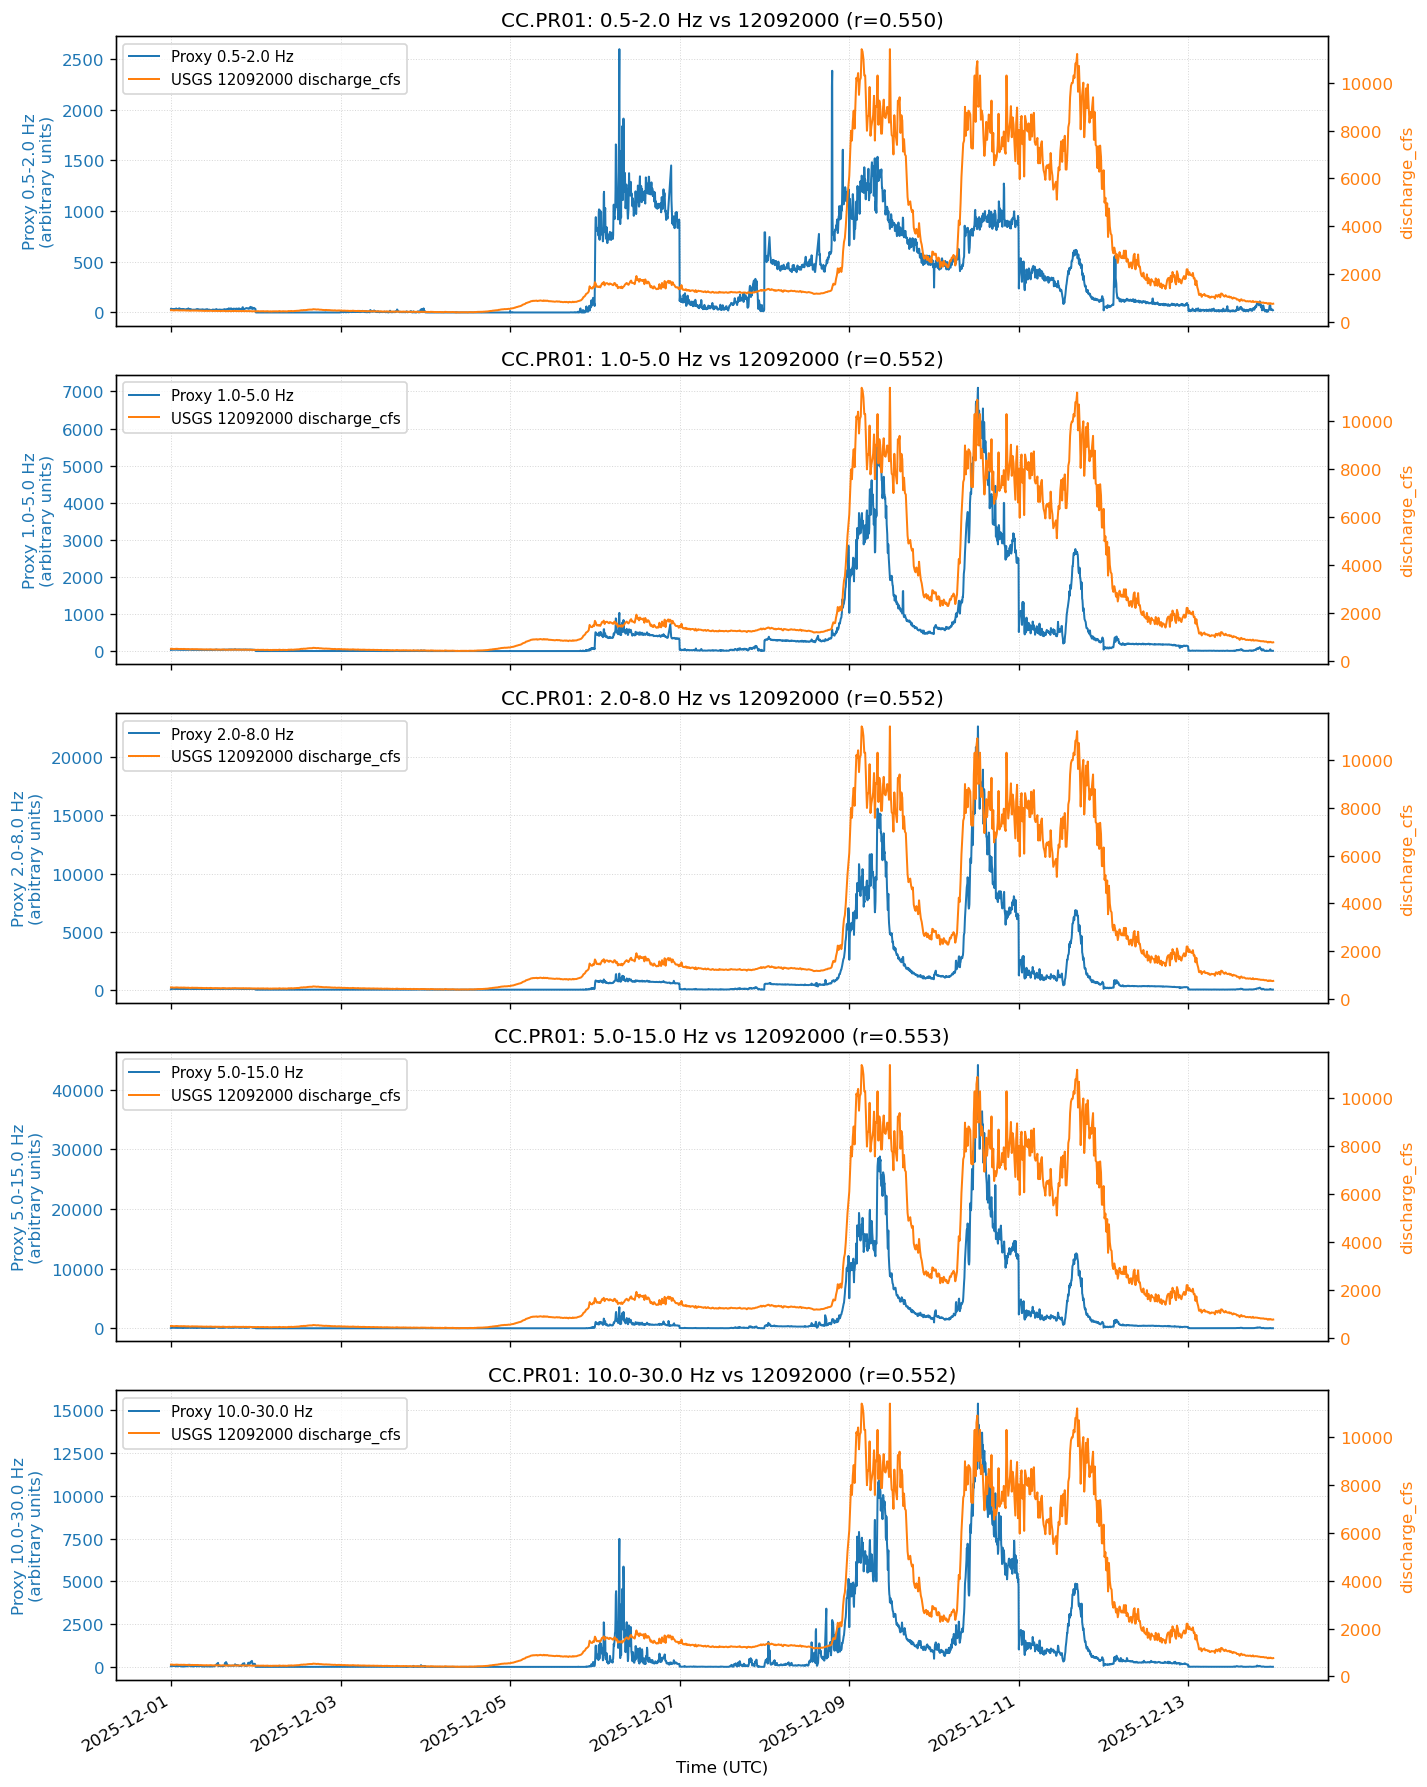


Best flow band (for lag selection): 2.0-8.0 Hz
Best bedload band (at fixed tau): 5.0-15.0 Hz
Chosen constant lag: 20.83 hours


In [36]:
# --- Plot all band proxies against discharge to compare before selecting best match ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(bands), 1, figsize=(12, 3 * len(bands)), sharex=True)
if len(bands) == 1:
    axes = [axes]

col = "discharge_cfs" if "discharge_cfs" in g.columns else "gage_height_ft"
gg_raw = g[[col]].dropna().sort_index()

for idx, band in enumerate(bands):
    ax1 = axes[idx]
    
    # Plot proxy on left axis
    p_band = band_proxies[band].dropna()
    ax1.plot(p_band.index, p_band.values, lw=1.2, color="tab:blue", 
             label=f"Proxy {band[0]}-{band[1]} Hz")
    ax1.set_ylabel(f"Proxy {band[0]}-{band[1]} Hz\n(arbitrary units)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="both", linestyle=":", linewidth=0.6, alpha=0.5)
    
    # Plot discharge on right axis
    ax2 = ax1.twinx()
    ax2.plot(gg_raw.index, gg_raw[col], lw=1.2, color="tab:orange",
             label=f"USGS {gid} {col}")
    ax2.set_ylabel(col, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    # Title and legend
    corr_val = band_score[band_score["band"] == f"{band[0]}-{band[1]}"]["corr_log10"].values
    corr_str = f"(r={corr_val[0]:.3f})" if len(corr_val) > 0 else ""
    ax1.set_title(f"{sta_key}: {band[0]}-{band[1]} Hz vs {gid} {corr_str}")
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=9)

axes[-1].set_xlabel("Time (UTC)")
plt.setp(axes[-1].get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
plt.show()

print(f"\nBest flow band (for lag selection): {BEST_FLOW_BAND[0]}-{BEST_FLOW_BAND[1]} Hz")
print(f"Best bedload band (at fixed tau): {BEST_BED_BAND[0]}-{BEST_BED_BAND[1]} Hz")
print(f"Chosen constant lag: {BEST_TAU_S/3600:.2f} hours")

Best bedload band at fixed tau: 5.0–15.0 Hz (corr=0.553)
Reference flow band: 2.0–8.0 Hz
Thresholded analysis: keeping q >= 1524.00 (60% percentile), n=466/1165


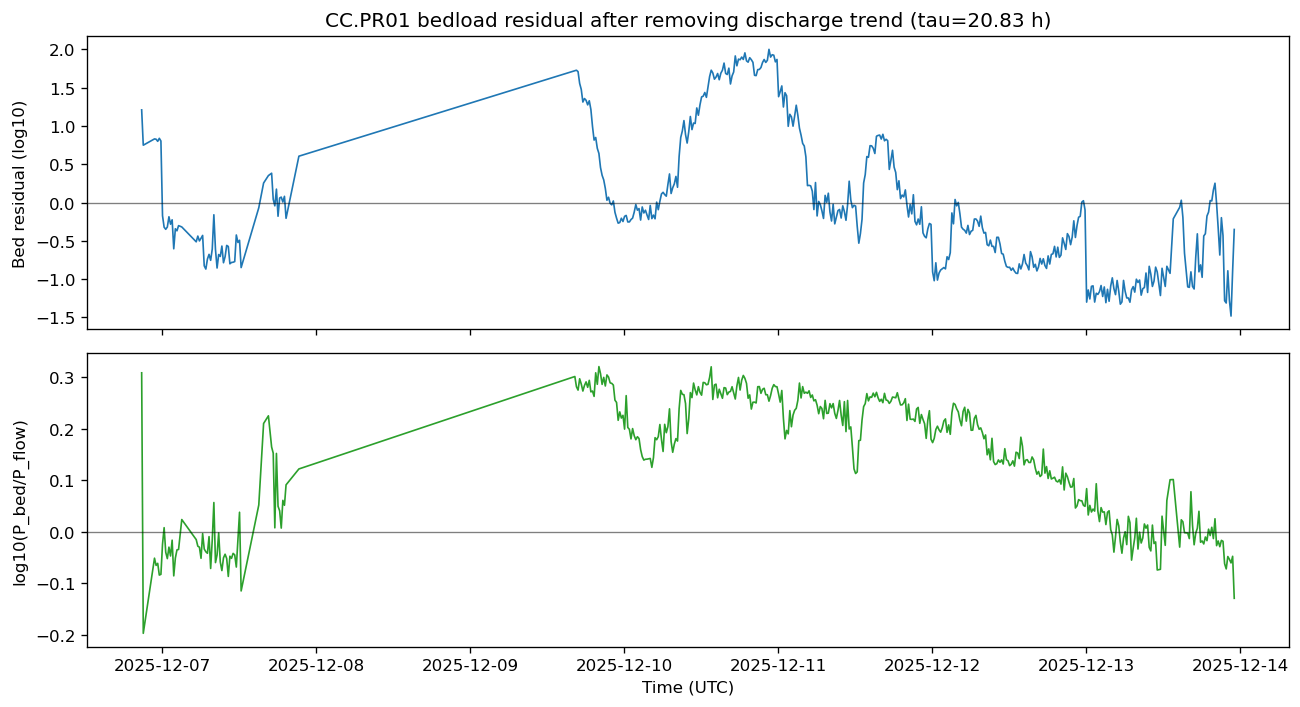

In [37]:
# --- Bedrock-river oriented diagnostics (Mt. Rainier style): threshold + residual/ratio ---
import matplotlib.pyplot as plt

# pick best bedload band among the provided BEDLOAD_BANDS at the chosen constant lag
bed_scores = band_score[band_score["band"].isin([f"{b[0]}-{b[1]}" for b in BEDLOAD_BANDS])].copy()
if bed_scores.empty:
    raise RuntimeError("No BEDLOAD_BANDS found in band_score")
best_bed_row = bed_scores.iloc[0]
BEST_BED_BAND = (float(best_bed_row["fmin"]), float(best_bed_row["fmax"]))
print(f"Best bedload band at fixed tau: {BEST_BED_BAND[0]}–{BEST_BED_BAND[1]} Hz (corr={best_bed_row['corr_log10']:.3f})")

BEST_FLOW_BAND = best_flow_band
print(f"Reference flow band: {BEST_FLOW_BAND[0]}–{BEST_FLOW_BAND[1]} Hz")

p_flow = band_proxies[BEST_FLOW_BAND].rename("p_flow")
p_bed = band_proxies[BEST_BED_BAND].rename("p_bed")
col = "discharge_cfs" if "discharge_cfs" in g.columns else "gage_height_ft"
gg = g[[col]].dropna().sort_index().copy()
gg.index = gg.index + pd.Timedelta(seconds=float(BEST_TAU_S))
gg = gg[col].rename("q")

df = pd.concat([p_flow, p_bed, gg], axis=1).dropna()
if len(df) < 30:
    raise RuntimeError("Not enough overlapping samples after applying tau")

tiny = np.finfo(float).tiny
df["log_flow"] = np.log10(df["p_flow"].clip(lower=tiny))
df["log_bed"] = np.log10(df["p_bed"].clip(lower=tiny))
df["log_q"] = np.log10(df["q"].clip(lower=tiny))

# Physical constraint: only interpret bedload/supply proxies above an effective transport threshold.
# Here we use a simple discharge percentile threshold (edit if you have a site-specific Qc).
Q_THRESH_PCT = 0.60
q_thr = float(df["q"].quantile(Q_THRESH_PCT))
df_hi = df[df["q"] >= q_thr].copy()
print(f"Thresholded analysis: keeping q >= {q_thr:.2f} ({Q_THRESH_PCT:.0%} percentile), n={len(df_hi)}/{len(df)}")

# Residual proxy: remove the best-fit log-linear dependence on discharge (hydraulic control).
m, b = np.polyfit(df_hi["log_q"].values, df_hi["log_bed"].values, 1)
df_hi["bed_resid"] = df_hi["log_bed"] - (m * df_hi["log_q"] + b)
df_hi["ratio_bed_flow"] = df_hi["log_bed"] - df_hi["log_flow"]

fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
ax[0].plot(df_hi.index, df_hi["bed_resid"], lw=1.0)
ax[0].axhline(0, color="k", lw=0.8, alpha=0.5)
ax[0].set_ylabel("Bed residual (log10)")
ax[0].set_title(f"{sta_key} bedload residual after removing discharge trend (tau={BEST_TAU_S/3600:.2f} h)")

ax[1].plot(df_hi.index, df_hi["ratio_bed_flow"], lw=1.0, color="tab:green")
ax[1].axhline(0, color="k", lw=0.8, alpha=0.5)
ax[1].set_ylabel("log10(P_bed/P_flow)")
ax[1].set_xlabel("Time (UTC)")
plt.tight_layout()
plt.show()

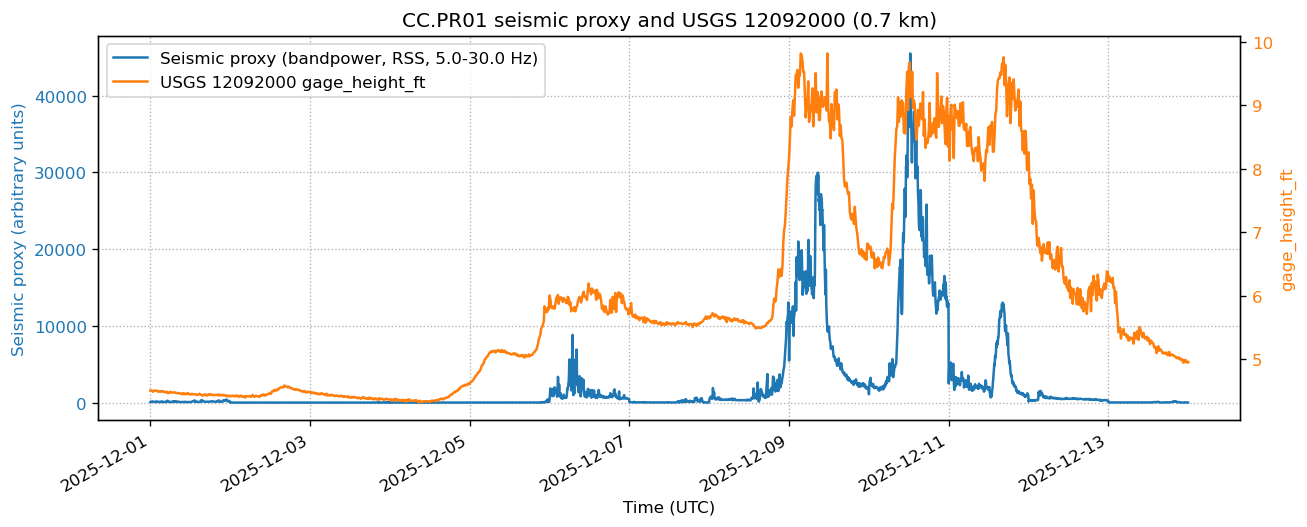

In [38]:
import matplotlib.pyplot as plt

# pick one station and its paired USGS gauge
sta_key = FOCUS_SEIS_KEY or list(proxies.keys())[0]
gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

p = proxies[sta_key]
g = gauges[gid].copy()

dist_km = STATION_META.get(sta_key, {}).get("gage_distance_km")
dist_str = f" ({dist_km:.1f} km)" if dist_km is not None else ""

rss_str = "RSS" if USE_RSS else "Z"
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# --- Seismic proxy (left axis) ---
ax1.plot(
    p.index,
    p.values,
    lw=1.5,
    color="tab:blue",
    label=f"Seismic proxy ({PROXY_METHOD}, {rss_str}, {FMIN}-{FMAX} Hz)"
 )
ax1.set_ylabel("Seismic proxy (arbitrary units)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# --- River stage / discharge (right axis) ---
ax2 = ax1.twinx()
stage_col = "gage_height_ft" if "gage_height_ft" in g.columns else ("discharge_cfs" if "discharge_cfs" in g.columns else None)
if stage_col is None:
    raise KeyError(f"Gauge {gid} has no gage_height_ft or discharge_cfs columns")

ax2.plot(
    g.index,
    g[stage_col],
    lw=1.5,
    color="tab:orange",
    linestyle="-",
    label=f"USGS {gid} {stage_col}"
 )
ax2.set_ylabel(stage_col, color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# --- Common formatting ---
ax1.set_title(f"{sta_key} seismic proxy and USGS {gid}{dist_str}")
ax1.set_xlabel("Time (UTC)")
ax1.grid(True, which="both", linestyle=":", linewidth=0.8)
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()

## 4) Plotting and diagnostics

We provide:
- time-series overlay (proxy vs stage)
- hysteresis scatter plot (proxy vs stage)
- optional frequency-band sweep to test sensitivity


In [39]:
from utils import plot_proxy_and_gauge, hysteresis_plot, band_sweep

### Run comparisons for your station↔gauge pairings


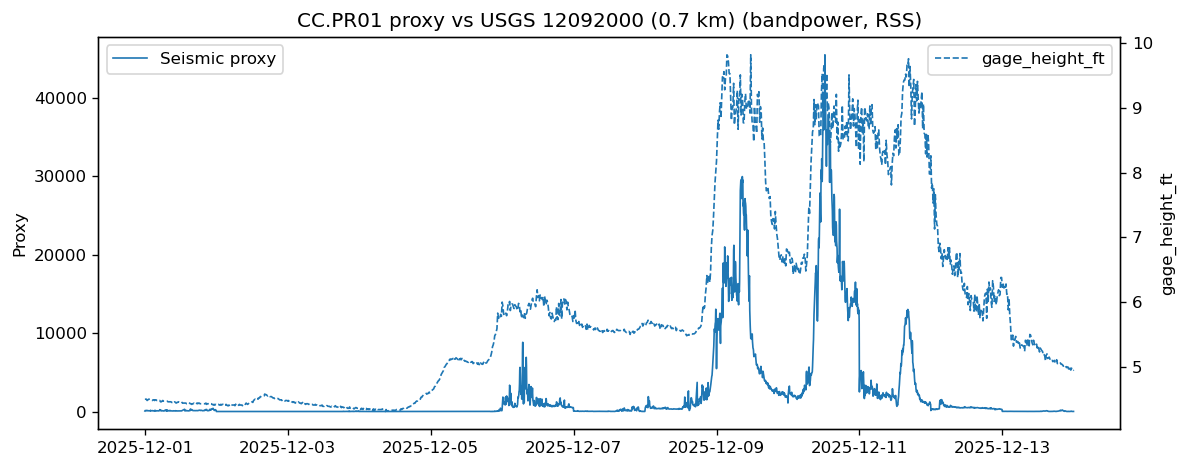

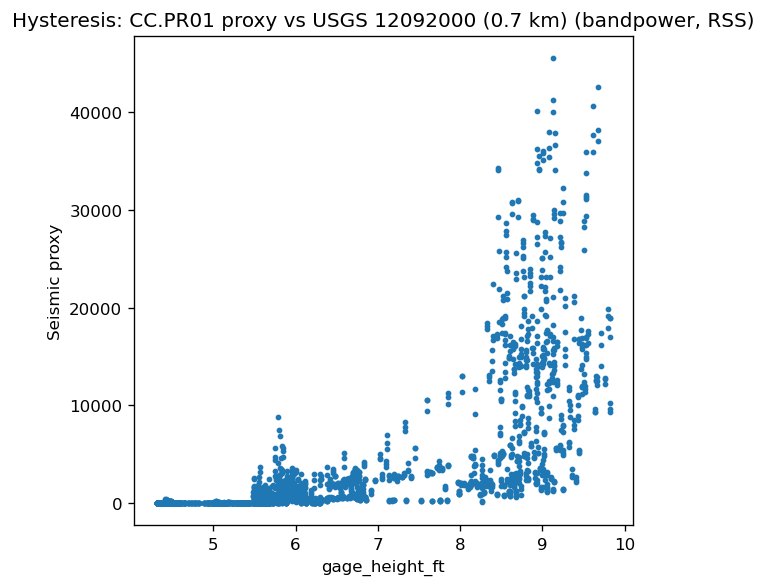

In [40]:
# Run comparisons for station↔gage pairings derived from metadata
rss_str = "RSS" if USE_RSS else "Z"
for sta_key, gid in PAIRINGS.items():
    if sta_key not in proxies:
        print(f"Skipping {sta_key} ↔ {gid} (missing seismic proxy)")
        continue
    if gid not in gauges:
        print(f"Skipping {sta_key} ↔ {gid} (missing gauge data)")
        continue

    dist_km = STATION_META.get(sta_key, {}).get("gage_distance_km")
    dist_str = f" ({dist_km:.1f} km)" if dist_km is not None else ""

    title = f"{sta_key} proxy vs USGS {gid}{dist_str} ({PROXY_METHOD}, {rss_str})"
    plot_proxy_and_gauge(proxies[sta_key], gauges[gid], title=title)
    hysteresis_plot(proxies[sta_key], gauges[gid], title=f"Hysteresis: {title}")

## 5) Next steps (toward sediment flux)

If you see a robust storm-correlated seismic band and **lag/hysteresis** relative to stage/discharge, the next upgrades are:

1. Replace RMS with **Welch PSD band power** per window.
2. Add a **coherence check** vs a reference station far from rivers (to suppress cultural noise).
3. Calibrate against any independent sediment proxy (geophones, turbidity/SSC, event yields).
4. Implement a **physics-based model/inversion** (Gimbert-style) if you have grain-size distributions and geometry.

If you want, paste the channel IDs printed above (or station metadata), and we can tighten channel selection (e.g., vertical-only vs RSS, exact HN? codes per site).
